# Newtork Tour of Data Science
# Stackoverflow survey
Claudio Loureiro, Cyril van Schreven, Cem Musluoglu, Jordan Willemin

# Introduction
We choose for our dataset the Stackoverflow 2017 survey. Stackoverflow is a forum where people help each other for programming questions. The questions of the survey range from professional to personal, from concrete to abstract. The aim of this project is to see if there are correlation within the Stackoverflow dataset taken from [here](https://www.kaggle.com/stackoverflow/so-survey-2017/data). We start from data visualisation then we perform spectral analysis and finally we develop a prediction model. There is detailed information about the questions in the file __survey_results_schema.csv__.

In [2]:
%matplotlib inline

from functions import *
import seaborn as sns
import networkx as nx
import numpy as np
from scipy.sparse import csgraph
import pandas as pd
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
import random
from operator import add
import configparser
import os
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from sklearn import preprocessing, decomposition
import librosa
import IPython.display as ipd
import itertools
from sklearn import preprocessing, decomposition, linear_model
import texttable as tt

plt.rcParams['figure.figsize'] = (17, 5)

# 1. Dataset and cleaning

### 1.1 Dataset
We first import our raw dataset. We start with 20 features. Here we consider each asked question as a feature. So an example of feature would be "Country". For this first part we choose features that seem the most meaningful to us.

In [3]:
user_data=pd.read_csv('data/survey_results_public.csv', index_col=0, squeeze=True,usecols=['Respondent','Country','FormalEducation',\
                                                                                           'EmploymentStatus','HaveWorkedLanguage','ProgramHobby',\
                                                                                          'HomeRemote','CompanyType','YearsCodedJob','DeveloperType',\
                                                                                          'CareerSatisfaction','PronounceGIF','JobSeekingStatus',\
                                                                                          'StackOverflowFoundAnswer','StackOverflowCopiedCode',\
                                                                                          'HoursPerWeek'])
# Number of normal features
nb_reg_fts = 15  # don't count "Respondent" nor "HaveWorkedLanguage"

# Number of code features
nb_code_fts = 5

### 1.2 Cleaning
After the import we need to start cleaning the answers and delete data with little interest for our study i.e. the unanswered questions or "_I prefer not answer_" are removed. We will also group data that is equivalent for example : "_Not employed, but looking for work_" and "_Not employed, and not looking for work_" is considered as "_Not employed_".

In [4]:
# Cleaning of our dataset

# Country cleaning
# Drop the users from countries with less than 250 respondents
country_count=user_data['Country'].value_counts()
user_data=user_data[user_data['Country'].isin(country_count[country_count > 250].index)]

# Employment Status 
user_data=user_data[user_data['EmploymentStatus'] != 'I prefer not to say']
user_data.loc[user_data['EmploymentStatus']=='Not employed, and not looking for work','EmploymentStatus']='Not employed'
user_data.loc[user_data['EmploymentStatus']=='Not employed, but looking for work','EmploymentStatus']='Not employed'

# Formal Education
user_data=user_data[user_data['FormalEducation'] != 'I prefer not to answer']

#FormalEducation
user_data.loc[user_data['FormalEducation']=="Master's degree",'FormalEducation']='Graduate'
user_data.loc[user_data['FormalEducation']=="Doctoral degree",'FormalEducation']='Graduate'
user_data.loc[user_data['FormalEducation']=="Bachelor's degree",'FormalEducation']='Undergraduate'
user_data.loc[user_data['FormalEducation']=="Secondary school",'FormalEducation']='No higher education degree'
user_data.loc[user_data['FormalEducation']=="Primary/elementary school",'FormalEducation']='No higher education degree'
user_data.loc[user_data['FormalEducation']=="Some college/university study without earning a bachelor's degree",'FormalEducation']='No higher education degree'
user_data.loc[user_data['FormalEducation']=="I never completed any formal education",'FormalEducation']='No higher education degree'

#HaveWorkedLanguage
user_data=user_data[user_data['HaveWorkedLanguage'].notnull()]

#CareerSatisfaction
user_data= user_data[np.isfinite(user_data['CareerSatisfaction'])]
user_data = user_data[pd.to_numeric(user_data['CareerSatisfaction'], errors='coerce').notnull()]

#remove all users than have any NaN (unanswered questions)
for feature in user_data.columns[0:nb_reg_fts+1]:
    user_data=user_data[~user_data[feature].isnull()]


Then we will encode in a binary way the programming language for each user. If a user knows how to program in a specific language, this programming langage is set to one.

In [5]:
# Programming languages
kept_languages = ['Python','R','Java','SQL','Scala']
for language in kept_languages:
    language_user=user_data['HaveWorkedLanguage'].apply(lambda x : language in str(x).split('; '))
    user_data.assign(language=[0]*len(user_data))
    user_data[language]=np.where(language_user,1,0)

#HaveWorkedLanguage is not necessary anymore
del user_data['HaveWorkedLanguage']

We chose to structure our data in a Panda dataframe and we will display the last four rows of our dataframe after this cleaning step.

In [6]:
user_data.tail(4)

,ProgramHobby,Country,EmploymentStatus,FormalEducation,HomeRemote,CompanyType,YearsCodedJob,DeveloperType,CareerSatisfaction,PronounceGIF,JobSeekingStatus,HoursPerWeek,StackOverflowFoundAnswer,StackOverflowCopiedCode,Python,R,Java,SQL,Scala
Respondent,,,,,,,,,,,,,,,,,,,
51385,No,United States,Employed full-time,Undergraduate,Never,Government agency or public school/university,8 to 9 years,Web developer,7.0,Some other way,"I'm not actively looking, but I am open to new...",0.0,Several times,Haven't done at all,0,0,0,0,0
51387,"Yes, both",Romania,Employed full-time,No higher education degree,It's complicated,"Privately-held limited company, not in startup...",3 to 4 years,Web developer; Mobile developer; Developer wit...,7.0,"With a soft ""g,"" like ""jiff""","I'm not actively looking, but I am open to new...",2.0,At least once each week,Once or twice,0,0,1,1,0
51388,"Yes, I program as a hobby",United States,Employed full-time,Undergraduate,A few days each month,I don't know,1 to 2 years,Web developer; Developer with a statistics or ...,7.0,"With a soft ""g,"" like ""jiff""",I am actively looking for a job,5.0,Several times,Haven't done at all,1,0,0,1,0
51391,"Yes, I program as a hobby",United States,Employed full-time,Undergraduate,Never,"Sole proprietorship or partnership, not in sta...",3 to 4 years,Web developer; Mobile developer,6.0,"With a soft ""g,"" like ""jiff""","I'm not actively looking, but I am open to new...",1.0,At least once each week,Once or twice,0,0,0,0,0


# 2. Statiscal studies

Before analysing the correlation of our entire dataset, we can start by doing some 1v1 comparisons in order to use the results of the comparisons to establish later conclusions.

### 2.1 Country vs Programming Language

We start by visualising the effect of programming language in function of the country from where the user comes. To realise this we will display histograms. 

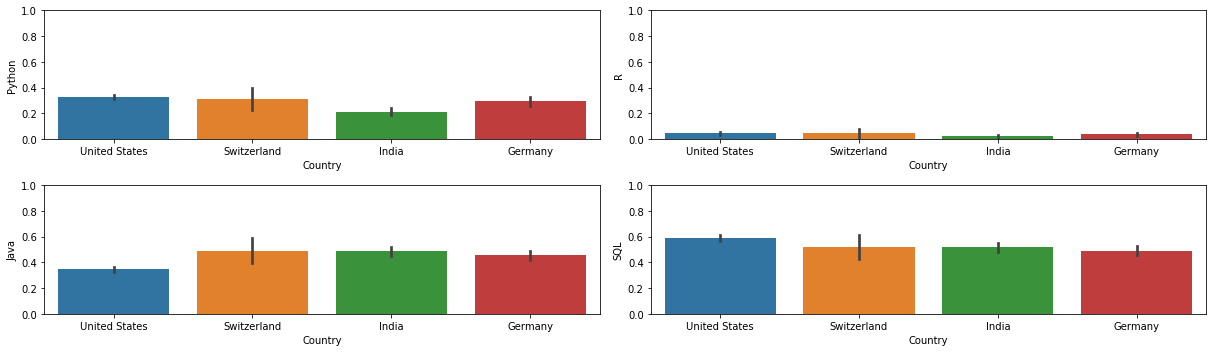

In [8]:
order = ['United States', 'Switzerland', 'India', 'Germany']
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="Country", y="Python", data=user_data, order=order)
plt.ylim(0,1)

ax2 = fig.add_subplot(222)
sns.barplot(x="Country", y="R", data=user_data, order=order)
plt.ylim(0,1)

ax3 = fig.add_subplot(223)
sns.barplot(x="Country", y="Java", data=user_data, order=order)
plt.ylim(0,1)

ax4 = fig.add_subplot(224)
sns.barplot(x="Country", y="SQL", data=user_data, order=order)
plt.ylim(0,1)

fig.tight_layout()
plt.show()

As we can see Java is less popular in the United States than in Switzerland and on the other hand SQL is more popular in the United States than in Switzerland.

### 2.2 Country vs Career satisfaction

Text(0.5,1,'Country vs Career Satisfaction')

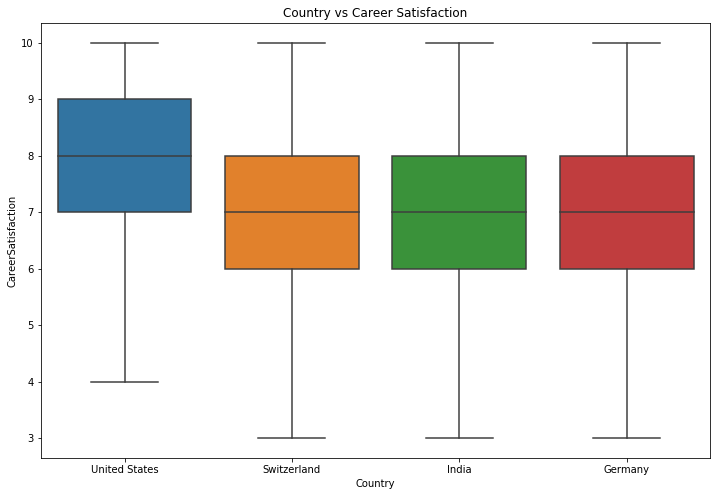

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="Country", y="CareerSatisfaction", data=user_data, order=order,showfliers=False)
plt.title('Country vs Career Satisfaction')

Overall the American Stackoverflow users are more satisfied with their career than the users from the three other countries displpayed here.

### 2.3 Country vs Hours per week
The feature __HoursPerWeek__ is the answer to the question: "during a typical week, approximately how many hours do you spend on activities related to finding new job opportunities".

Text(0.5,1,'Country vs Hours per week')

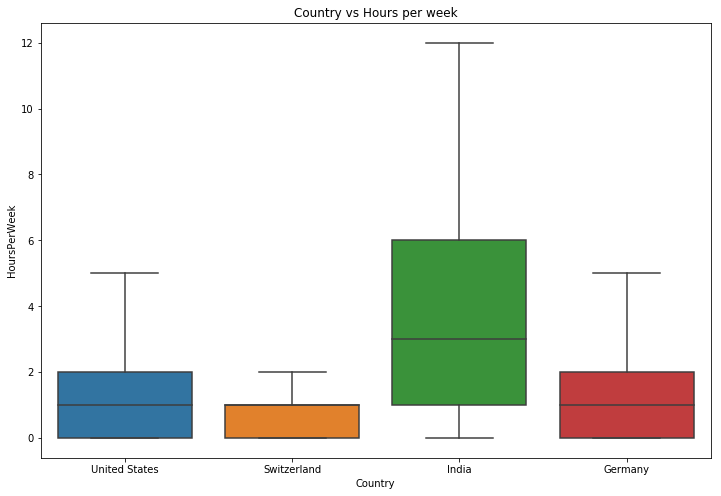

In [12]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="Country", y="HoursPerWeek", data=user_data, order=order,showfliers=False)
plt.title('Country vs Hours per week')

It is quite obvious that people in India spend more hours in searching new job opportunities.

## 3. Spectral Graph Study (First part)

Too see if a correlation exists bewtween certain feature and the dataset, we remove it from our dataframe. From our dataframe we create our network. Then we look if the tested feature creates clusters in the graph. In our case we will use the "Country" feature.

In [13]:
N,M =user_data.shape
feature_tested = user_data['Country']
del user_data['Country']

In [14]:
# We create numerical features for our matrix 
features_mat = np.zeros([N,nb_reg_fts-1])
for i, feature in enumerate(user_data.columns[0:nb_reg_fts-1]):
    features_mat[:,i] = preprocessing.LabelEncoder().fit_transform(user_data[feature])

### 3.1 Weight Matrix
To create a weight matrix which is an extension of an adjacency matrix where the value of the edges could be higher than one. In our study the nodes correspond to the user answering the survey and the edges are created between two nodes if users have answered at least one question the same. More precisely the weight of the edge is increased by one for each answer they have in common.

In [15]:
W = np.zeros([N,N])
W_unordered = np.zeros(int((N**2-N)/2))

#Adding all features except programming languages
for feature in user_data.columns[0:nb_reg_fts-1]:
    for j, ft in enumerate(itertools.combinations(user_data[feature], 2)):
        W_unordered[j]=W_unordered[j]+1*(ft[0]==ft[1])
    print('Done with feature:',feature)
    
#Adding programming languages
for feature in user_data.columns[nb_reg_fts-1:nb_reg_fts+nb_code_fts-1]:        
    for j, ft in enumerate(itertools.combinations(user_data[feature], 2)):
        W_unordered[j]=W_unordered[j]+ft[0]*ft[1]
    print('Done with feature:',feature)
        
upr_inds = np.triu_indices(N,1)
W[upr_inds]=W_unordered     #fill upper triangle
W = np.where(W==0, W.T, W)  #fill lower triangle s.t matrix is symmetric

Done with feature: ProgramHobby
Done with feature: EmploymentStatus
Done with feature: FormalEducation
Done with feature: HomeRemote
Done with feature: CompanyType
Done with feature: YearsCodedJob
Done with feature: DeveloperType
Done with feature: CareerSatisfaction
Done with feature: PronounceGIF
Done with feature: JobSeekingStatus
Done with feature: HoursPerWeek
Done with feature: StackOverflowFoundAnswer
Done with feature: StackOverflowCopiedCode
Done with feature: Python
Done with feature: R
Done with feature: Java
Done with feature: SQL
Done with feature: Scala


Once all the weights are assigned we need to sparsify our matrix in order to have a nice visualisation. Here we decide to remove the 85% of the lowest weights. Another method could be performed for this task: keeping the k strongest edges for each node.

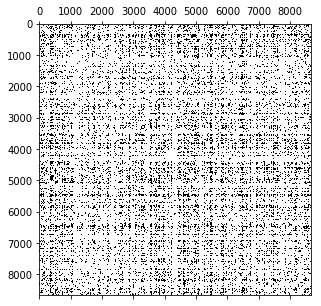

In [16]:
P = 85/100
nul_inds = np.argsort(np.ravel(W))[:int(N**2*P)]
W[(nul_inds/W.shape[0]).astype(int),nul_inds%W.shape[0]] = 0
#np.ravel(W)[np.argsort(np.ravel(W))[:nul_inds]]=0
W = np.where(W==0, W.T, W)
np.fill_diagonal(W,0)
plt.spy(W)

### 3.2 Degree distribution

We can then easily plot the degree distribution of our network.

(array([ 248.,  379.,  372.,  485.,  456.,  458.,  440.,  400.,  447.,
         428.,  408.,  365.,  333.,  340.,  357.,  307.,  295.,  273.,
         227.,  214.,  211.,  171.,  157.,  122.,  106.,  110.,   92.,
          74.,   68.,   67.,   61.,   38.,   26.,   30.,   23.,   17.,
          14.,   14.,    9.,   10.,    2.,    4.,    4.,    6.,    5.,
           0.,    0.,    1.,    0.,    1.]),
 array([  1.60000000e+01,   9.55320000e+02,   1.89464000e+03,
          2.83396000e+03,   3.77328000e+03,   4.71260000e+03,
          5.65192000e+03,   6.59124000e+03,   7.53056000e+03,
          8.46988000e+03,   9.40920000e+03,   1.03485200e+04,
          1.12878400e+04,   1.22271600e+04,   1.31664800e+04,
          1.41058000e+04,   1.50451200e+04,   1.59844400e+04,
          1.69237600e+04,   1.78630800e+04,   1.88024000e+04,
          1.97417200e+04,   2.06810400e+04,   2.16203600e+04,
          2.25596800e+04,   2.34990000e+04,   2.44383200e+04,
          2.53776400e+04,   2.63169600e+04

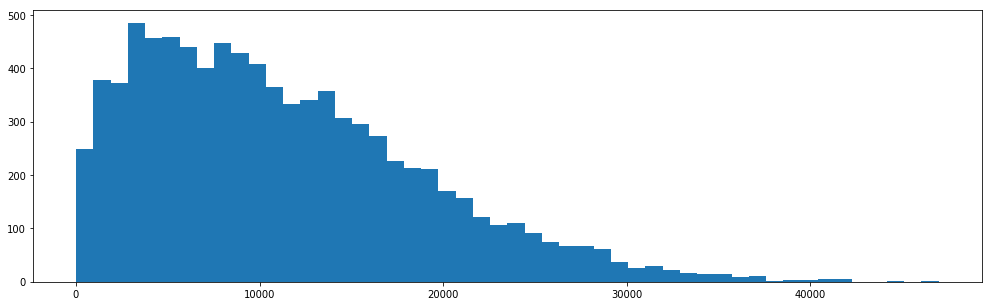

In [17]:
degrees = W.sum(axis=1)
plt.hist(degrees, bins=50)

_Remark_ : This plot represents the weighted degree distribution.

### 3.3 Visualising the clusters in the adjacency matrix 

We try to visualise if countries form clusters in the adjacency matrix.

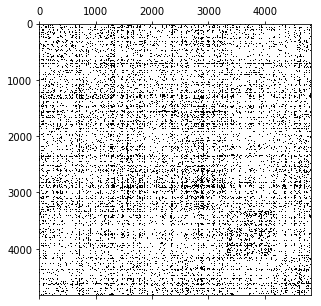

In [18]:
ind_US = list(np.where(feature_tested=="United States")[0])
ind_UK = list(np.where(feature_tested=="United Kingdom")[0])
ind_IN = list(np.where(feature_tested=="India")[0])
ind_GE = list(np.where(feature_tested=="Germany")[0])
ind_separate = ind_US + ind_UK + ind_IN + ind_GE

weights_separate =[[W[i][j] for j in ind_separate] for i in ind_separate]
plt.spy(weights_separate)

### 3.4 Laplacian

By using our weight matrix we can easily compute the Laplacian

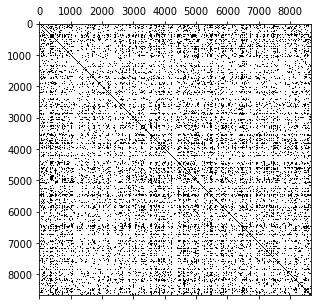

In [19]:
L = scipy.sparse.csgraph.laplacian(W, normed=True)
plt.spy(L)
L = sparse.csr_matrix(L)

### 3.5 Eigendecomposition of the graph Laplacian

We decompose our Laplacian by calculating the eigenvalues and the eigenvectors.

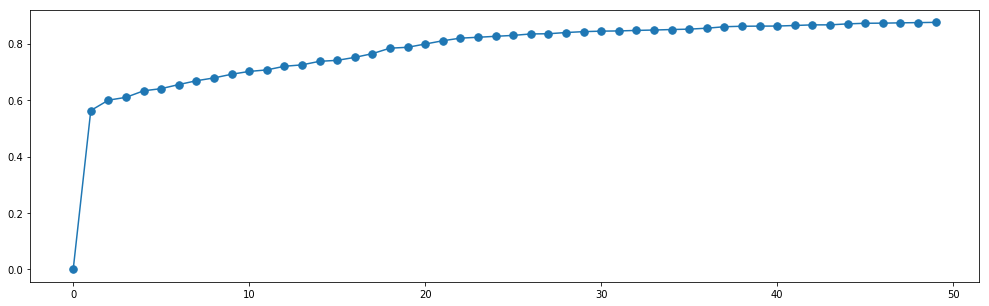

In [20]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(L,k=50,which='SM')
plt.plot(eigenvalues, '.-', markersize=15)

We see that the graph is connected since the second eigenvalue (algebraic connectivity) is greater than 0.

### 3.6 Principal component analysis (PCA)
To visualise our data in 2D we can use the PCA algorithm. It permits to reduce the dimensionality of a dataset. It computes the axes of principal variance and project the data on them. In our example, each color represent a different country.

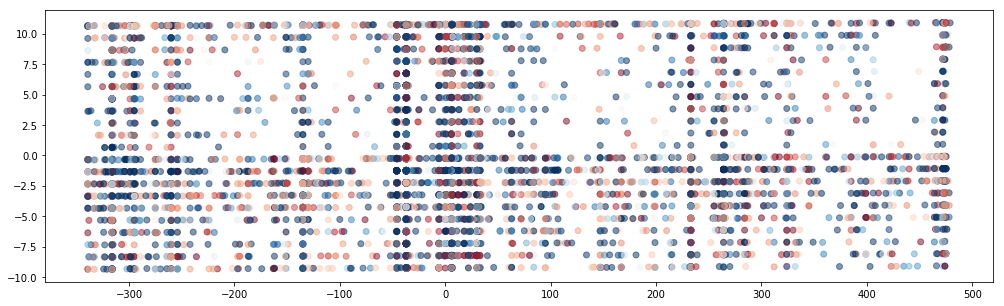

In [21]:
features_pca = decomposition.PCA(n_components=2).fit_transform(features_mat)
country_label = preprocessing.LabelEncoder().fit_transform(feature_tested)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=country_label, cmap='RdBu', alpha=0.5);

### 3.7 Graph Embedding
Another way to embed a graph is to use the value of the eigenvectors as coordinates. For the below plot, we use the value of the second eigenvector as the x coordinate of a node, and the value of the third eigenvector as the y coordinate.

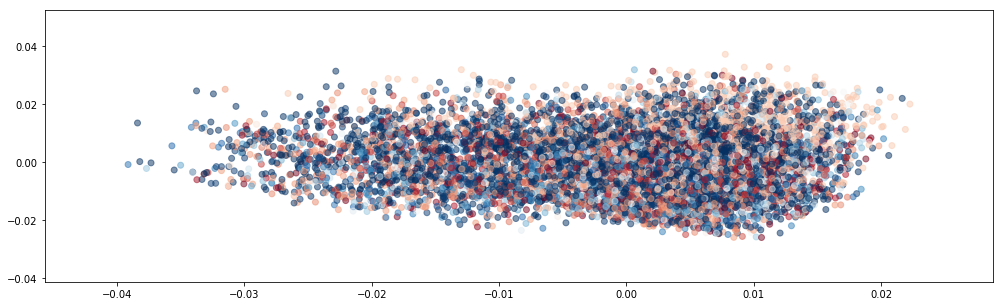

In [22]:
x = eigenvectors[:,1]
y = eigenvectors[:,2]
plt.scatter(x, y, c=country_label, cmap='RdBu', alpha=0.5);

We see unfortunately that there is no obvious "Country" cluster.

## 4. Spectral Graph Study (Second part)

Previously we have seen that the dataset features are not really correlated with the feature we were testing : "Country". In order to have better results we choose another set of features among our dataset. In the next part the tested feature will be "ProblemSolving". This feature answer the question : "I love solving problems". The other features have been selected as personal view toward programming.

__Remark__: The code snippets used in the next parts are the same as in section 3 only the dataset is changing so we will not comment until the data visualisation.

In [23]:
user_data_modified = pd.read_csv('data/survey_results_public.csv', index_col=0, squeeze=True,usecols=['Respondent','ProgramHobby','PronounceGIF','ProblemSolving',\
                                                                                           'BuildingThings','LearningNewTech','BoringDetails',\
                                                                                          'AnnoyingUI','FriendsDevelopers','RightWrongWay',\
                                                                                          'InvestTimeTools','KinshipDevelopers','ClickyKeys',\
                                                                                          'TabsSpaces','ShipIt','OtherPeoplesCode',\
                                                                                          'EnjoyDebugging','InTheZone'])
nb_reg_fts = 17
for feature in user_data_modified.columns[0:nb_reg_fts+1]:
    user_data_modified=user_data_modified[~user_data_modified[feature].isnull()]

Here we fix the number of users to 3000 to speed up calculations.

In [24]:
N = 3000   
samples=random.sample(range(0,len(user_data_modified)),N)
samples=sorted(samples,key=int)
user_sampled_data_modified = user_data_modified.iloc[samples,:]

### 4.1 Weighted Matrix

In [25]:
feature_tested_modified = user_sampled_data_modified['ProblemSolving']
del user_sampled_data_modified['ProblemSolving']

features_mat_modified = np.zeros([N,nb_reg_fts-1])
for i, feature in enumerate(user_sampled_data_modified.columns[0:nb_reg_fts-1]):
    features_mat_modified[:,i] = preprocessing.LabelEncoder().fit_transform(user_sampled_data_modified[feature])
    
W = np.zeros([N,N])
W_unordered = np.zeros(int((N**2-N)/2))
for feature in user_sampled_data_modified.columns[0:nb_reg_fts-1]:
    for j, ft in enumerate(itertools.combinations(user_sampled_data_modified[feature], 2)):
        W_unordered[j]=W_unordered[j]+1*(ft[0]==ft[1])
    print('Done with feature:',feature)
        
upr_inds = np.triu_indices(N,1)
W[upr_inds]=W_unordered     #fill upper triangle
W = np.where(W==0, W.T, W)  #fill lower triangle s.t matrix is symmetric

Done with feature: ProgramHobby
Done with feature: PronounceGIF
Done with feature: BuildingThings
Done with feature: LearningNewTech
Done with feature: BoringDetails
Done with feature: AnnoyingUI
Done with feature: FriendsDevelopers
Done with feature: RightWrongWay
Done with feature: InvestTimeTools
Done with feature: KinshipDevelopers
Done with feature: ClickyKeys
Done with feature: TabsSpaces
Done with feature: ShipIt
Done with feature: OtherPeoplesCode
Done with feature: EnjoyDebugging
Done with feature: InTheZone


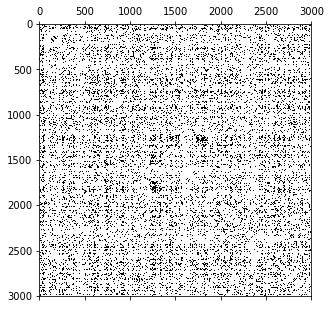

In [26]:
P = 85/100
nul_inds = np.argsort(np.ravel(W))[:int(N**2*P)]
W[(nul_inds/W.shape[0]).astype(int),nul_inds%W.shape[0]] = 0
W = np.where(W==0, W.T, W)
np.fill_diagonal(W,0)
plt.spy(W)

### 4.2 Visualising the clusters in the adjacency matrix 

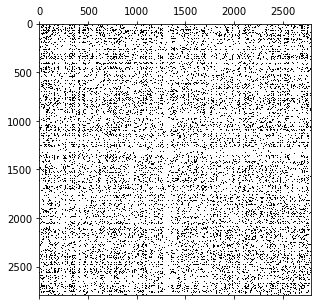

In [27]:
#testing ProblemSolving
ind_strongly = list(np.where(feature_tested_modified=="Strongly agree")[0])
ind_agree = list(np.where(feature_tested_modified=="Agree")[0])
ind_separate = ind_strongly+ind_agree
weights_separate =[[W[i][j] for j in ind_separate] for i in ind_separate]
plt.spy(weights_separate)

### 4.3 laplacian Eigenmaps

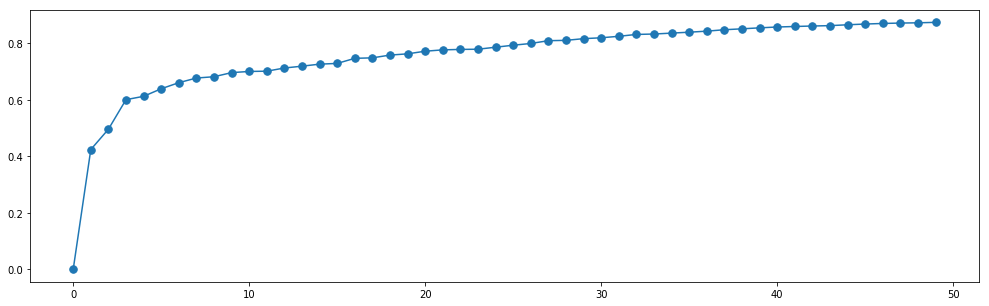

In [39]:
L = scipy.sparse.csgraph.laplacian(W, normed=True)
L = sparse.csr_matrix(L)
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(L,k=50,which='SM')
plt.plot(eigenvalues, '.-', markersize=15)

### 4.4 Principal component analysis (PCA)

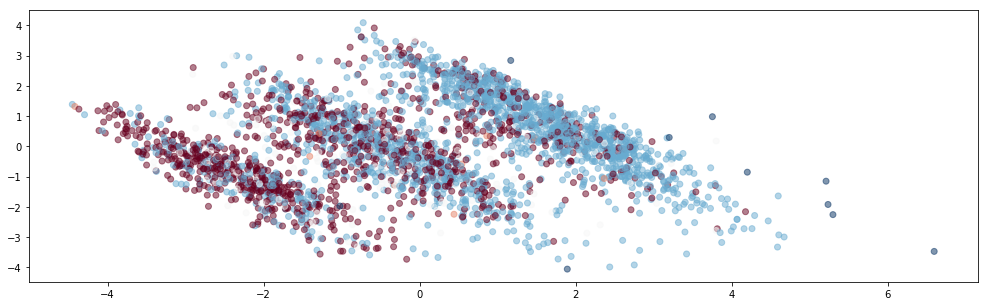

In [40]:
features_pca = decomposition.PCA(n_components=4).fit_transform(features_mat_modified)
problemSolving = preprocessing.LabelEncoder().fit_transform(feature_tested_modified)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=problemSolving, cmap='RdBu', alpha=0.5);

### 4.5 Graph Embedding

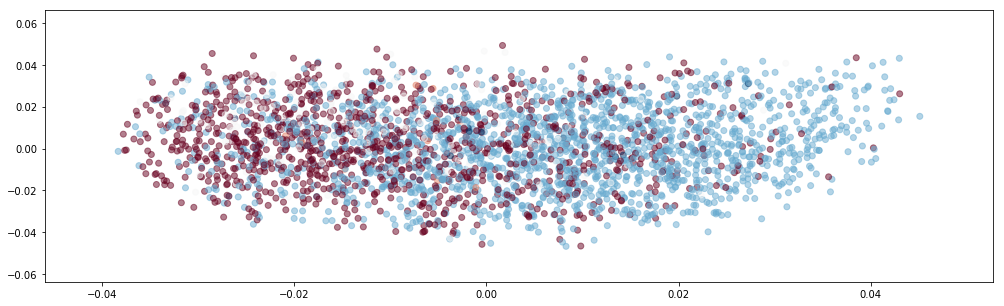

In [41]:
x = eigenvectors[:, 1]
y = eigenvectors[:, 3]
plt.scatter(x, y, c=problemSolving, cmap='RdBu', alpha=0.5);

Now we can see some correlation between "ProblemSolving" feature and the others chosen features. Though not very clean there are two separate clusters in this graph.

# 5. Machine Learning

After trying to manually find the features that are the most correlated, we now try to find a correlation with an algorithm.

In this part we try to predict from which country a user comes, from the chosen features. The features can be split into three subgroups: the "personnal information" features, the "StackOverflow" features and the "Programming language" features.

### 5.1 Preparing the data

In [4]:
user_data=pd.read_csv('data/survey_results_public.csv', index_col=0, squeeze=True,usecols=['Respondent','StackOverflowFoundAnswer','StackOverflowCopiedCode',\
                                                                                           'StackOverflowJobListing','StackOverflowCompanyPage',\
                                                                                          'StackOverflowJobSearch','StackOverflowNewQuestion',\
                                                                                          'StackOverflowAnswer','StackOverflowMetaChat',\
                                                                                          'ProblemSolving','BuildingThings','LearningNewTech',\
                                                                                          'BoringDetails','JobSecurity','DiversityImportant',\
                                                                                          'AnnoyingUI','FriendsDevelopers','RightWrongWay',\
                                                                                          'UnderstandComputers','SeriousWork','InvestTimeTools',\
                                                                                          'WorkPayCare','KinshipDevelopers','ChallengeMyself',\
                                                                                          'CompetePeers','ChangeWorld','Country','HaveWorkedLanguage'])
kept_languages = ['Python','R','Java','SQL','Scala','C','C#','JavaScript','Assembly','PHP']
for language in kept_languages:
    language_user=user_data['HaveWorkedLanguage'].apply(lambda x : language in str(x).split('; '))
    user_data.assign(language=[0]*len(user_data))
    user_data[language]=np.where(language_user,1,0)
del user_data['HaveWorkedLanguage']

In [5]:
nb_fts = len(user_data.columns)
nb_stack_fts = 8
nb_perso_fts = 17
nb_language_fts = 10

In [6]:
kept_countries = ('Germany','India','United Kingdom','Canada','France','Poland','Australia','Spain','Netherlands','Russian Federation','Sweden','Brazil','Israel')
user_data = user_data.loc[user_data['Country'].isin(kept_countries)]

In [7]:
#remove all users than have any NaN (unanswered questions)

for feature in user_data.columns[0:nb_fts+1]:
    user_data=user_data[~user_data[feature].isnull()]

Randomly select N samples to keep amongst the data

In [8]:
N = 10000 
samples=random.sample(range(0,len(user_data)),N)
samples=sorted(samples,key=int)
user_sampled_data=user_data.iloc[samples,:]

In [9]:
#deleting the feature Country because it is the one we try to predict
feature_tested = user_sampled_data['Country']
del user_sampled_data['Country']

### 5.2 Predicting

In [10]:
#Convert feature to predict to numerical
# when FormalEducation: -1 = no higher degree, 0 = undergraduate, 1 = graduate
# when Country: -1 = Germany, 0 = India, 1 = United Kingdom
preproc_country = preprocessing.LabelEncoder()
label = preproc_country.fit_transform(feature_tested) 

#Create numerical features matrix 
features_mat_stack = np.zeros([N,nb_stack_fts])
features_mat_perso = np.zeros([N,nb_perso_fts])

preproc_perso = preprocessing.LabelEncoder()
preproc_stack = preprocessing.LabelEncoder()

#for personnal features; 0 = disagree, 1 = somewhat agree, 2 = agree, 3 = strongly agree
for i, feature in enumerate(user_sampled_data.columns[0:nb_perso_fts]):
    features_mat_perso[:,i] = preproc_perso.fit_transform(user_sampled_data[feature])
features_mat_perso = np.where(features_mat_perso<=2, features_mat_perso-1, features_mat_perso) 
features_mat_perso = np.where(features_mat_perso==-1, features_mat_perso+3, features_mat_perso) 

#for StackOverflow features; 0 = haven't done at all, 1 = once or twice, 2 = several times, 3 = at least once each week, 4 = at least once each day
for i, feature in enumerate(user_sampled_data.columns[nb_perso_fts:nb_perso_fts+nb_stack_fts]):
    features_mat_stack[:,i] = preproc_stack.fit_transform(user_sampled_data[feature])
features_mat_stack = np.where(features_mat_stack>=2, features_mat_stack-2, -features_mat_stack+4) 

#for programming language features; 0 = haven't worked with this language, 1 = have worked with this language
features_mat_language = np.array(user_sampled_data[user_sampled_data.columns[nb_perso_fts+nb_stack_fts:nb_perso_fts+nb_stack_fts+nb_language_fts]])

features_mat = np.column_stack((features_mat_perso,features_mat_stack,features_mat_language))

### With "personal information" features

In [11]:
k_fold = 5
k_indices = crossvad_build_k_indices(label, k_fold,1)
label_pred, accuracy, acc_variance = cross_validation(label, features_mat_perso, k_indices, k_fold)
print('The prediction accuracy using the "personnal information" features is:', format(accuracy))

The prediction accuracy using the "personnal information" features is: 0.1891


### with StackOverflow features 

In [12]:
k_fold = 5
k_indices = crossvad_build_k_indices(label, k_fold,2)
label_pred, accuracy, acc_variance = cross_validation(label, features_mat_stack, k_indices, k_fold)
print('The prediction accuracy using the "StackOverflow" features is:', format(accuracy))

The prediction accuracy using the "StackOverflow" features is: 0.1543


### With programming languages features

In [13]:
k_fold = 5
k_indices = crossvad_build_k_indices(label, k_fold,1)
label_pred, accuracy, acc_variance = cross_validation(label, features_mat_language, k_indices, k_fold)
print('The prediction accuracy using the "programming language" features is:', format(accuracy))

The prediction accuracy using the "programming language" features is: 0.1749


### With all features

In [14]:
k_fold = 5
k_indices = crossvad_build_k_indices(label, k_fold,2)
label_pred, accuracy, acc_variance = cross_validation(label, features_mat, k_indices, k_fold)
print('The prediction accuracy using all the features is:', format(accuracy))

The prediction accuracy using all the features is: 0.2104


In [15]:
print('Without any correlation, the accuracy would be of:',format((1/len(kept_countries))))

Without any correlation, the accuracy would be of: 0.07692307692307693


We can see from these results that the 'personnal information' features vary more from country to country than the 'StackOverflow' features and the 'Programming language' features.

### 5.3 Verifying the predictions are balanced

The point of this machine learning algorithm is not to make predictions that are as accurate as possible, but to show there is a correlation between the input features and the country of the user. The prediction has been forced to be balanced to keep a faithful prediction. If not balanced only two or three of the most present countries will always be predicted, and the correlation between the input features and the other countries would not be tested at all.

(array([  386.,   360.,   547.,   641.,   709.,  1664.,   846.,   437.,
          464.,  1008.,   542.,   571.,  1825.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.]),
 <a list of 13 Patch objects>)

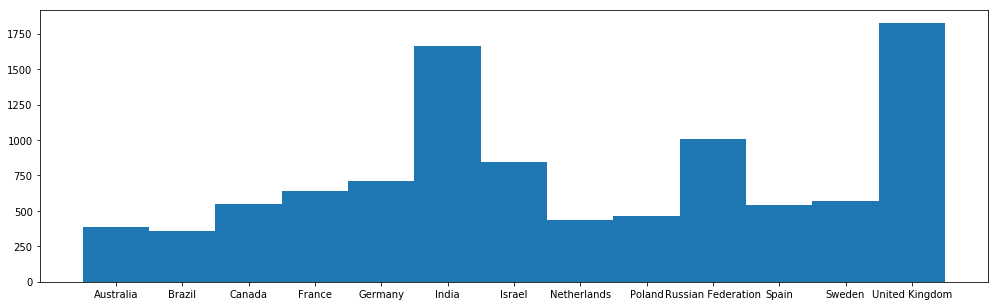

In [16]:
plt.xticks(range(0,len(kept_countries)),preproc_country.inverse_transform(range(0,len(kept_countries))))
plt.hist(label_pred,len(kept_countries),(0,len(kept_countries)),align='left')

(array([  452.,   332.,  1041.,   725.,  1819.,  1386.,   237.,   416.,
          556.,   348.,   335.,   303.,  2050.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.]),
 <a list of 13 Patch objects>)

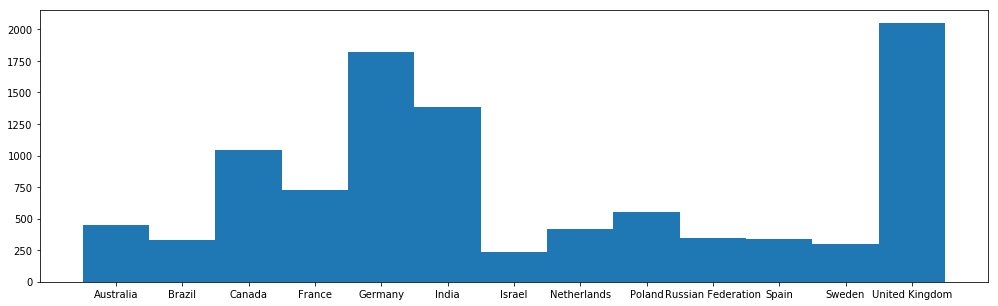

In [17]:
plt.xticks(range(0,len(kept_countries)),preproc_country.inverse_transform(range(0,len(kept_countries))))
plt.hist(label,len(kept_countries),(0,len(kept_countries)),align='left')

### 5.4 Analyzing correlations

Let's now look at which input features had the highest impact on the classification.

### 'Personnal information' features
Recall that a 'personnal info' feature is 'high' if the user strongly agrees with the statement. It is low if the user disagrees with the statement. 

In [18]:
logreg = linear_model.LogisticRegression(solver ='liblinear', class_weight ='balanced')
logreg.fit(features_mat_perso, label)
pos_important_fts  = []
neg_important_fts = []
for i in range(0, len(kept_countries)):
    pos_important_fts.append(user_sampled_data.columns[logreg.coef_[i].argsort()[-2:][::-1]])
    neg_important_fts.append(user_sampled_data.columns[logreg.coef_[i].argsort()[:2]])

In [19]:
tab = tt.Texttable()
tab.header(['Country','1st important positive','2nd important positive','1st important negative','2nd important negative'])
rows = np.column_stack((preproc_country.inverse_transform(range(0,13)),pos_important_fts,neg_important_fts))
tab.set_cols_width([20,20,20,20,20])
for i in range(0,len(kept_countries)):
    tab.add_row(rows[i])
print(tab.draw())   

+----------------------+----------------------+----------------------+----------------------+----------------------+
|       Country        |    1st important     |    2nd important     |    1st important     |    2nd important     |
|                      |       positive       |       positive       |       negative       |       negative       |
+======================+======================+======================+======================+======================+
| Australia            | BuildingThings       | ChallengeMyself      | LearningNewTech      | SeriousWork          |
+----------------------+----------------------+----------------------+----------------------+----------------------+
| Brazil               | SeriousWork          | BuildingThings       | KinshipDevelopers    | AnnoyingUI           |
+----------------------+----------------------+----------------------+----------------------+----------------------+
| Canada               | BuildingThings       | AnnoyingUI      

Many things can be read from this table, for example the best (positive) way to distinguish wether someone comes from Germany is to look if they 'strongly agree' with 'I take my work seriously'. 

On the other hand, the best (negative) way to distinguish wether someone comes from Brazil is if they disagree with 'I feel a sense of kinship to other developers'. 

### All features

In [20]:
logreg = linear_model.LogisticRegression(solver ='liblinear', class_weight ='balanced')
logreg.fit(features_mat, label)
pos_important_fts  = []
neg_important_fts = []
for i in range(0, len(kept_countries)):
    pos_important_fts.append(user_sampled_data.columns[logreg.coef_[i].argsort()[-2:][::-1]])
    neg_important_fts.append(user_sampled_data.columns[logreg.coef_[i].argsort()[:2]])

In [21]:
tab = tt.Texttable()
tab.header(['Country','1st important positive','2nd important positive','1st important negative','2nd important negative'])
rows = np.column_stack((preproc_country.inverse_transform(range(0,13)),pos_important_fts,neg_important_fts))
tab.set_cols_width([20,20,20,20,20])
for i in range(0,len(kept_countries)):
    tab.add_row(rows[i])
print(tab.draw())   

+----------------------+----------------------+----------------------+----------------------+----------------------+
|       Country        |    1st important     |    2nd important     |    1st important     |    2nd important     |
|                      |       positive       |       positive       |       negative       |       negative       |
+======================+======================+======================+======================+======================+
| Australia            | BuildingThings       | C#                   | C                    | LearningNewTech      |
+----------------------+----------------------+----------------------+----------------------+----------------------+
| Brazil               | SeriousWork          | Java                 | Scala                | KinshipDevelopers    |
+----------------------+----------------------+----------------------+----------------------+----------------------+
| Canada               | BuildingThings       | Python          

A 'StackOverflow' feature is high if the user very often realised the statement, it is low if the user never realised the statement. 

We can for example see here that if a user frequently 'searched for a job' on StackOverflow in the last 3 months, the chances are higher that he comes from Spain.

A 'Programming Language' feature is high (=1) if the user used it and it is low (=0) if he didn't.

We can see that if a user used PHP, it is more probable that he comes from the Netherlands